In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.optimize import fmin

import sys
sys.path.append("../src")

from data_prep import *
from make_cuts import *
from fitting_functions import *
from pulse_profile_generator import *
from plot_maker import *
from energy_resolution import *

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
runs=[300,301,302,303,304,305,307]

c_folder="../../data/calibration/"
d_folder="../../data/runData/"

In [4]:
%%time
p0_s=[]
p1_s=[]
e0_s=[]
e1_s=[]
for r_n in runs:
    # make folder for plots
    Path("../../plots").mkdir(parents=True, exist_ok=True)
    Path("../../plots/run_"+str(r_n)).mkdir(parents=True, exist_ok=True)
    p_folder="../../plots/run_"+str(r_n)+"/"

    p,m,r=import_data(c_folder,d_folder, r_n, is_it_pulsed=False)
    r=select_bars_with_data(r,p, subtract_pedestal=True, is_it_pulsed=False)
    r=first_layer_cut(r)
    r=back_layer_cut(r,5)

    p0,p1, e0, e1=make_gaussian_fit_plot(r,m,r_n,p_folder, save_plot=False)

    p0_s.append(p0[:-1])
    p1_s.append(p1[:-1])
    e0_s.append(e0[:-1])
    e1_s.append(e1[:-1])

Number of events: 71416


Initial pedestal-based selection performed.
Events left: 71415


Events with multiple hits in first layer removed.
Events left: 42333


Events with hits in the back 5 layers removed.
Events left: 31066


Number of events: 92038


Initial pedestal-based selection performed.
Events left: 91978


Events with multiple hits in first layer removed.
Events left: 63987


Events with hits in the back 5 layers removed.
Events left: 61267


Number of events: 100534


Initial pedestal-based selection performed.
Events left: 99704


Events with multiple hits in first layer removed.
Events left: 75163


Events with hits in the back 5 layers removed.
Events left: 73234


Number of events: 105912


Initial pedestal-based selection performed.
Events left: 104450


Events with multiple hits in first layer removed.
Events left: 80916


Events with hits in the back 5 layers removed.
Events left: 79071


Number of events: 67621


Initial pedestal-based selection performed.
Events 

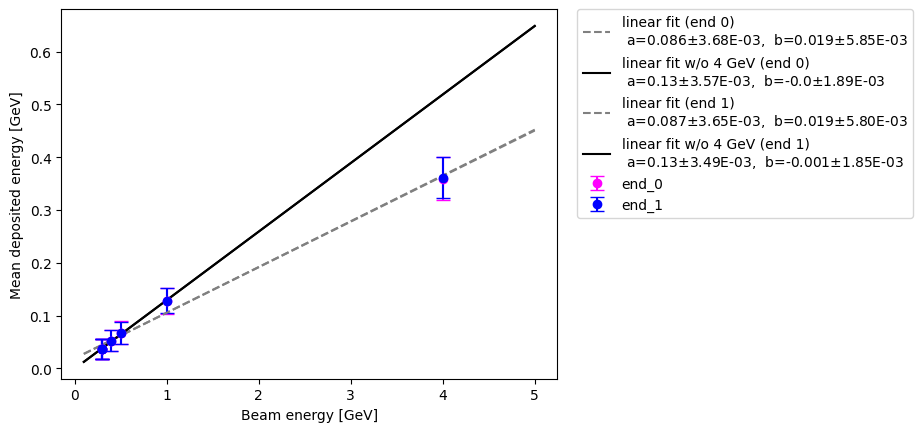

In [6]:
linear_plot(res_df, 0, True, low_df, False, True)
linear_plot(res_df, 1, True, low_df, True, True)

In [16]:
truth

run_number
300    0.110845
301    0.188966
302    0.313139
303    0.384773
304    0.506057
305    0.504154
307    0.507623
dtype: float64

In [22]:
errors=truth*np.sqrt((res_df["sigma_end0_err"]/res_df["sigma_end0"])**2 + (res_df["mu_end0_err"]/res_df["mu_end0"])**2)

In [10]:
res_df

,mu_end0,sigma_end0,mu_end1,sigma_end1,mu_end0_err,sigma_end0_err,beam_energy,particle_type
run_number,,,,,,,,
300,0.359532,0.039852,0.360822,0.039010,0.000344,0.000344,4.0,electron
301,0.128155,0.024217,0.127989,0.023744,0.000171,0.000171,1.0,electron
302,0.067787,0.021227,0.067496,0.021011,0.000462,0.000462,0.5,electron
303,0.052863,0.020340,0.052683,0.019948,0.000480,0.000482,0.4,electron
304,0.037149,0.018800,0.036966,0.018460,0.000264,0.000275,0.3,electron
305,0.037273,0.018791,0.037168,0.018485,0.000251,0.000262,0.3,electron
307,0.037347,0.018958,0.037152,0.018408,0.000290,0.000303,0.3,electron


In [12]:
def hyper_fit(redult_df, end, exclude_high_energy=False, low_result_df=None):
    mu="mu_end"+str(int(end))
    sigma="sigma_end"+str(int(end))

    truth=result_df[sigma]/result_df[mu]
    param, pcov=curve_fit(hyperbolic, result_df["beam_energy"], truth)
    perr=np.sqrt(np.diag(pcov))

    if exclude_high_energy==True:
        truth_low=low_result_df[sigma]/low_result_df[mu]
        param_low, pcov_low=curve_fit(hyperbolic, low_result_df["beam_energy"], truth_low)
        perr_low=np.sqrt(np.diag(pcov_low))
        return param, perr, param_low, perr_low

    return param, perr

In [13]:
def hyperbolic_correct(x,a,b,c):
    f=(a/np.sqrt(x))**2 + (b/x)**2 + c**2
    return np.sqrt(f)

In [23]:
truth=res_df["sigma_end0"]/res_df["mu_end0"]
errors=truth*np.sqrt((res_df["sigma_end0_err"]/res_df["sigma_end0"])**2 + (res_df["mu_end0_err"]/res_df["mu_end0"])**2)
# truth_low=low_df["sigma_end0"]/low_df["mu_end0"]

param, pcov=curve_fit(hyperbolic_correct, res_df["beam_energy"], truth, sigma=errors)
# param_low, pcov_low=curve_fit(hyperbolic_correct, low_df["beam_energy"], truth_low, p0=[0.05,0.1,0.1],xtol=0.005, maxfev=10000)

perr=np.sqrt(np.diag(pcov))
# perr_low=np.sqrt(np.diag(pcov_low))

In [24]:
param

array([0.07584344, 0.14242434, 0.09791481])

In [25]:
perr

array([0.00505133, 0.0013733 , 0.00119796])

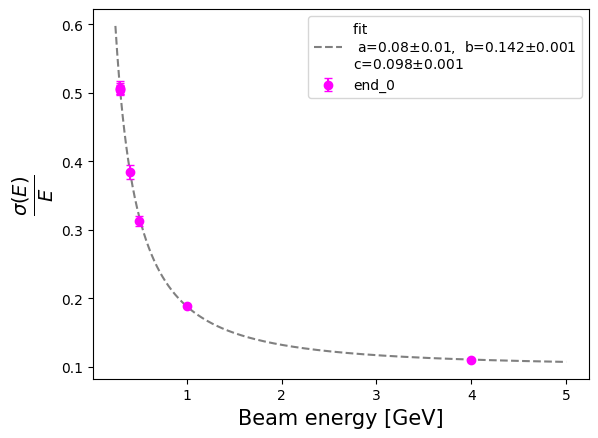

In [31]:
plt.errorbar(res_df["beam_energy"], res_df["sigma_end0"]/res_df["mu_end0"],errors, color="magenta",zorder=4,
             label="end_0", linestyle="", marker='o',capsize=3)
sample=np.linspace(0.25, 5, 1000)

plt.plot(sample, hyperbolic_correct(sample, *param), linestyle="--", color="gray",zorder=2,
         label=r"fit ""\n"" a="+str(round(param[0],2))+"$\pm$"+str(round(perr[0],2))+
         ",  b="+str(round(param[1],3))+"$\pm$"+str(round(perr[1],3))+ 
         "\n""c="+str(round(param[2],3))+"$\pm$"+str(round(perr[2],3)))

# plt.plot(sample, hyperbolic_correct(sample, *param_low), linestyle="-", color="black",zorder=3,
#          label=r"fit w/o 4 GeV ""\n"" a="+str(round(param_low[0],3))+"$\pm$"+str(round(perr_low[0],4))+
#          ",  b="+str(round(param_low[1],4))+"$\pm$"+str(round(perr_low[1],4))+
#          "\n""c="+str(round(param_low[2],4))+"$\pm$"+str(round(perr_low[2],4)))
plt.xlabel("Beam energy [GeV]", fontsize=15)
plt.ylabel(r"$\frac{\sigma (E)}{E}$", fontsize=20)
# plt.ylim(0,)
plt.legend()
plt.savefig("../../plots/hcal_resolution_electron_end_abc.png", bbox_inches='tight')
plt.show()

Number of events: 47351


Initial pedestal-based selection performed.
Events left: 46271


Events with multiple hits in first layer removed.
Events left: 37232


Events with hits in the back 5 layers removed.
Events left: 36506




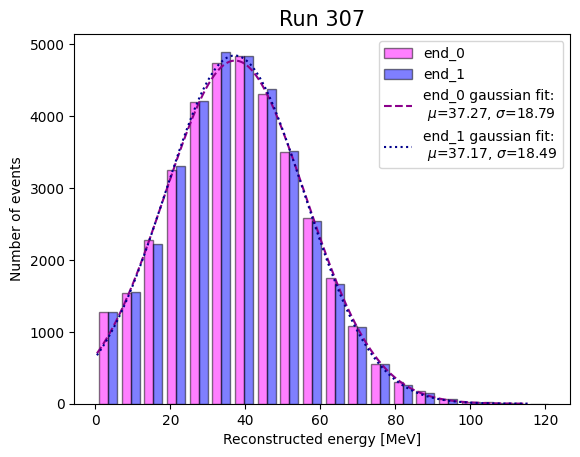

CPU times: user 9.32 s, sys: 1.93 s, total: 11.3 s
Wall time: 11.3 s


In [4]:
%%time
r_n=307

Path("../../plots").mkdir(parents=True, exist_ok=True)
Path("../../plots/run_"+str(r_n)).mkdir(parents=True, exist_ok=True)
p_folder="../../plots/run_"+str(r_n)+"/"

p,m,r=import_data(c_folder,d_folder, 305, is_it_pulsed=False)
r=select_bars_with_data(r,p, subtract_pedestal=True, is_it_pulsed=False)
r=first_layer_cut(r)
r=back_layer_cut(r,5)
p0,p1=make_gaussian_fit_plot(r,m,r_n,p_folder, save_plot=False)